# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install kaggle
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached pip-23.0.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
  Using cached setuptools-67.6.0-py3-none-any.whl (1.1 MB)
  Using cached wheel-0.38.4-py3-none-any.whl (36 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.4.0
    Uninstalling setuptools-59.4.0:
      Successfully uninstalled setuptools-59.4.0
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.2
    Uninstalling bokeh-2.4.2:
      Successfully uninstalled bokeh-2.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.5/292.5 kB 227.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 229.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

### Setup Kaggle API Key

In [3]:
# # create the .kaggle directory and an empty kaggle.json file
# !mkdir -p /root/.kaggle
# !touch /root/.kaggle/kaggle.json
# !chmod 600 /root/.kaggle/kaggle.json

In [4]:
# # Fill in your user name and key from creating the kaggle account and API token file
# import json
# kaggle_username = "abhijithaav"
# kaggle_key = "680cbf57755ec059a8d745970b18aa8b"

# # Save API token the kaggle.json file
# with open("/root/.kaggle/kaggle.json", "w") as f:
#     f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [5]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [4]:
import pandas as pd
from autogluon.tabular import TabularPredictor
from datetime import datetime
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [7]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
train = pd.read_csv('train.csv', parse_dates=['datetime'],
                date_parser=custom_date_parser)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [9]:
train.describe(include = 'all')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
unique,10886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2012-12-19 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,NaN,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,NaN,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000


In [10]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv', parse_dates=['datetime'],
                date_parser=custom_date_parser)
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [11]:
train = train.drop(['casual','registered'], axis=1)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [12]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'],
                date_parser=custom_date_parser)
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [13]:
predictor = TabularPredictor(label="count", 
            eval_metric = 'root_mean_squared_error'
                            ).fit(train_data=train, 
            time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20230313_181831/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230313_181831/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Feb 1 21:34:38 UTC 2023
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feat

### Review AutoGluon's training run with ranking of models that did the best.

In [14]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.800161      12.042006  441.234181                0.001092           0.437765            3       True         15
1   RandomForestMSE_BAG_L2  -53.394190      11.059845  409.201421                0.591593          26.304410            2       True         12
2     ExtraTreesMSE_BAG_L2  -53.822142      11.198045  390.952278                0.729793           8.055267            2       True         14
3          LightGBM_BAG_L2  -55.085650      10.719528  406.436740                0.251276          23.539729            2       True         11
4          CatBoost_BAG_L2  -55.624896      10.542177  444.317218                0.073925          61.420207            2       True         13
5        LightGBMXT_BAG_L2  -60.386086      13.942107  436.452887         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -

<AxesSubplot:xlabel='model'>

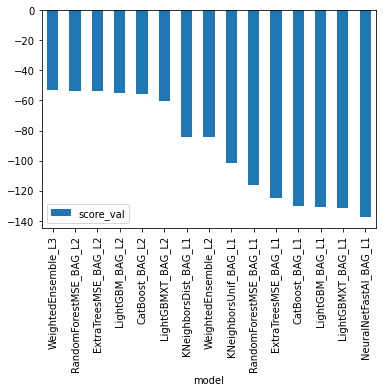

In [15]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

### Create predictions from test dataset

In [16]:
predictions = predictor.predict(test)
predictions.head()

0    24.892300
1    41.934944
2    45.790092
3    49.457123
4    52.013222
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [17]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.605286
std        90.181335
min         2.916262
25%        20.597862
50%        63.232391
75%       170.758850
max       365.223938
Name: count, dtype: float64

In [18]:
# How many negative values do we have?
has_negative = predictions.lt(0).any()

# print the result
if has_negative:
    print("The series has negative values.")
else:
    print("The series does not have negative values.")

The series does not have negative values.


In [19]:
# Set them to zero
predictions = predictions.apply(lambda x: 0 if x < 0 else x)

### Set predictions to submission dataframe, save, and submit

In [20]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [21]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [22]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

#### Initial score of 1.79038 

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

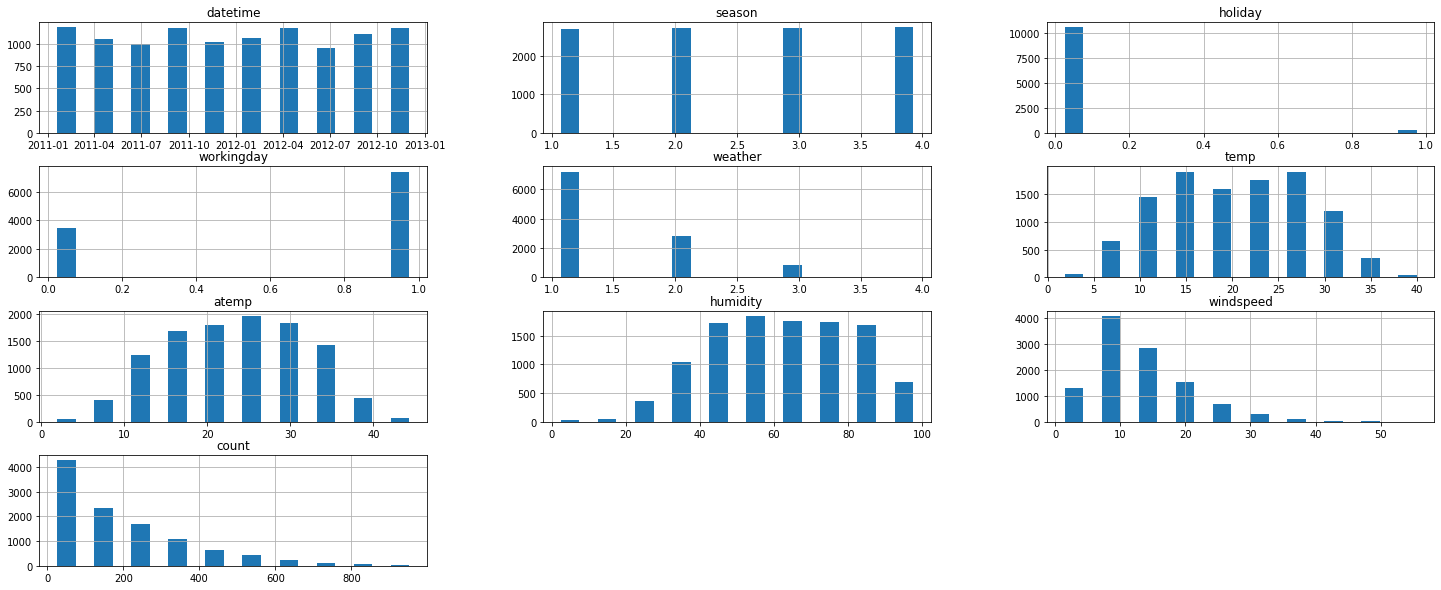

In [23]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
ax = train.hist(rwidth=0.5, figsize=(25, 10))

In [24]:
# create a new feature
train['hour'] = train['datetime'].dt.hour
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['year'] = train['datetime'].dt.year
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,month,day,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1,2011


In [25]:
for i in ['hour', 'month', 'day', 'year']:
    print("{} has :{}".format(i.capitalize(),train[i].unique())) #since year only has 2011 and 2012 two values they will be considered categorical

Hour has :[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Month has :[ 1  2  3  4  5  6  7  8  9 10 11 12]
Day has :[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Year has :[2011 2012]


In [26]:
train['is_2011'] = (train['year'] == 2011).astype(int)
train = train.drop(['datetime', 'year'], axis = 1)

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   count       10886 non-null  int64  
 9   hour        10886 non-null  int64  
 10  month       10886 non-null  int64  
 11  day         10886 non-null  int64  
 12  is_2011     10886 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 1.1 MB


In [28]:
# create a new feature
test['hour'] = test['datetime'].dt.hour
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['year'] = test['datetime'].dt.year
test['is_2011'] = (test['year'] == 2011).astype(int)
test = test.drop(['datetime', 'year'], axis = 1)
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,month,day,is_2011
0,1,0,1,1,10.66,11.365,56,26.0027,0,1,20,1
1,1,0,1,1,10.66,13.635,56,0.0000,1,1,20,1
2,1,0,1,1,10.66,13.635,56,0.0000,2,1,20,1
3,1,0,1,1,10.66,12.880,56,11.0014,3,1,20,1
4,1,0,1,1,10.66,12.880,56,11.0014,4,1,20,1


In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      6493 non-null   int64  
 1   holiday     6493 non-null   int64  
 2   workingday  6493 non-null   int64  
 3   weather     6493 non-null   int64  
 4   temp        6493 non-null   float64
 5   atemp       6493 non-null   float64
 6   humidity    6493 non-null   int64  
 7   windspeed   6493 non-null   float64
 8   hour        6493 non-null   int64  
 9   month       6493 non-null   int64  
 10  day         6493 non-null   int64  
 11  is_2011     6493 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 608.8 KB


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [30]:
train["season"] = train['season'].astype('category')
train["weather"] = train["weather"].astype('category')

test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')


In [31]:
for i in train.select_dtypes(include='category').columns.tolist():
    print("{} from train has : {} unique values".format(i.capitalize(), len(train[i].unique())))

Season from train has : 4 unique values
Weather from train has : 4 unique values


In [32]:
for i in test.select_dtypes(include='category').columns.tolist():
    print("{} from test has : {} unique values".format(i.capitalize(), len(test[i].unique())))

Season from test has : 4 unique values
Weather from test has : 4 unique values


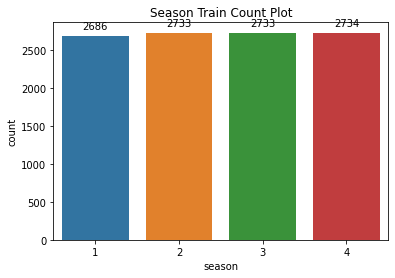

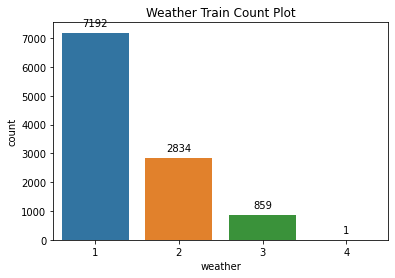

In [33]:
for col in train.select_dtypes(include='category').columns.tolist():
    ax = sns.countplot(x=col, data=train)
    ax.set_title(col.capitalize() + ' Train Count Plot')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')
    plt.show()

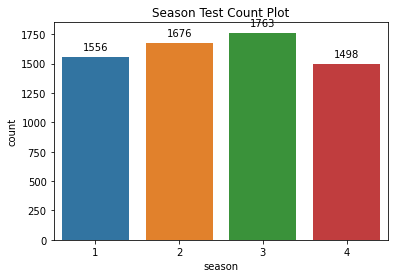

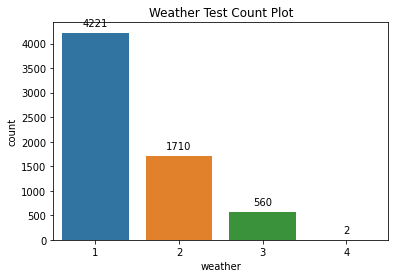

In [34]:
for col in test.select_dtypes(include='category').columns.tolist():
    ax = sns.countplot(x=col, data=test)
    ax.set_title(col.capitalize() + ' Test Count Plot')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')
    plt.show()

In [35]:
train['weather'] = train['weather'].replace(4, 3)
test['weather'] = test['weather'].replace(4, 3)

In [36]:
# View are new feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,month,day,is_2011
0,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1,1
1,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1,1
3,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1,1
4,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1,1


In [37]:
# Create correlation matrix # Create correlation plot
corr = train.corr()
corr

,holiday,workingday,temp,atemp,humidity,windspeed,count,hour,month,day,is_2011
holiday,1.000000,-0.250491,0.000295,-0.005215,0.001929,0.008409,-0.005393,-0.000354,0.001731,-0.015877,-0.012021
workingday,-0.250491,1.000000,0.029966,0.024660,-0.010880,0.013373,0.011594,0.002780,-0.003394,0.009829,0.002482
temp,0.000295,0.029966,1.000000,0.984948,-0.064949,-0.017852,0.394454,0.145430,0.257589,0.015551,-0.061226
atemp,-0.005215,0.024660,0.984948,1.000000,-0.043536,-0.057473,0.389784,0.140343,0.264173,0.011866,-0.058540
humidity,0.001929,-0.010880,-0.064949,-0.043536,1.000000,-0.318607,-0.317371,-0.278011,0.204537,-0.011335,0.078606
windspeed,0.008409,0.013373,-0.017852,-0.057473,-0.318607,1.000000,0.101369,0.146631,-0.150192,0.036157,0.015221
count,-0.005393,0.011594,0.394454,0.389784,-0.317371,0.101369,1.000000,0.400601,0.166862,0.019826,-0.260403
hour,-0.000354,0.002780,0.145430,0.140343,-0.278011,0.146631,0.400601,1.000000,-0.006818,0.001132,0.004234
month,0.001731,-0.003394,0.257589,0.264173,0.204537,-0.150192,0.166862,-0.006818,1.000000,0.001974,0.004932
day,-0.015877,0.009829,0.015551,0.011866,-0.011335,0.036157,0.019826,0.001132,0.001974,1.000000,-0.001800


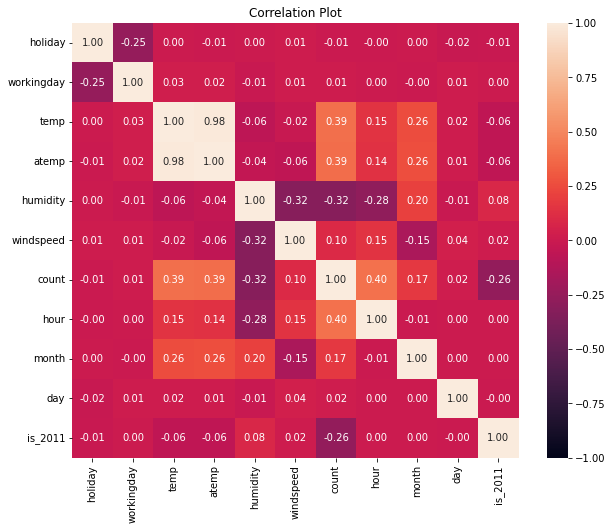

In [38]:
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True , fmt='.2f', vmin=-1, vmax=1,)
plt.title("Correlation Plot")
plt.show()

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  int64   
 2   workingday  10886 non-null  int64   
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   count       10886 non-null  int64   
 9   hour        10886 non-null  int64   
 10  month       10886 non-null  int64   
 11  day         10886 non-null  int64   
 12  is_2011     10886 non-null  int64   
dtypes: category(2), float64(3), int64(8)
memory usage: 957.2 KB


In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      6493 non-null   category
 1   holiday     6493 non-null   int64   
 2   workingday  6493 non-null   int64   
 3   weather     6493 non-null   category
 4   temp        6493 non-null   float64 
 5   atemp       6493 non-null   float64 
 6   humidity    6493 non-null   int64   
 7   windspeed   6493 non-null   float64 
 8   hour        6493 non-null   int64   
 9   month       6493 non-null   int64   
 10  day         6493 non-null   int64   
 11  is_2011     6493 non-null   int64   
dtypes: category(2), float64(3), int64(7)
memory usage: 520.4 KB


In [41]:
num_cols = [col for col in train.select_dtypes(include=['int', 'float']).columns.tolist() 
            if col not in ['count', 'holiday', 'workingday', 'is_2011']]
num_cols
# # Standardize numerical variables
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])

In [42]:
train.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,count,hour,month,day,is_2011
count,10886.000000,10886.000000,1.088600e+04,1.088600e+04,1.088600e+04,1.088600e+04,10886.000000,1.088600e+04,1.088600e+04,1.088600e+04,10886.000000
mean,0.028569,0.680875,3.133020e-16,-2.193114e-16,1.148774e-16,-5.221699e-17,191.574132,6.657667e-17,8.354719e-17,-9.137974e-18,0.498071
std,0.166599,0.466159,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,181.144454,1.000046e+00,1.000046e+00,1.000046e+00,0.500019
min,0.000000,0.000000,-2.491372e+00,-2.701736e+00,-3.215858e+00,-1.567754e+00,1.000000,-1.668944e+00,-1.603121e+00,-1.642070e+00,0.000000
25%,0.000000,0.000000,-8.074281e-01,-8.248654e-01,-7.735577e-01,-7.101642e-01,42.000000,-8.013299e-01,-7.320958e-01,-9.116571e-01,0.000000
50%,0.000000,1.000000,3.454398e-02,6.902305e-02,5.899992e-03,2.432639e-02,145.000000,6.628379e-02,1.389299e-01,1.358704e-03,0.000000
75%,0.000000,1.000000,7.712696e-01,8.738177e-01,7.853577e-01,5.142603e-01,284.000000,9.338975e-01,1.009956e+00,9.143745e-01,1.000000
max,1.000000,1.000000,2.665707e+00,2.572501e+00,1.980526e+00,5.413599e+00,977.000000,1.656909e+00,1.590639e+00,1.644787e+00,1.000000


array([[<AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'is_2011'}>, <AxesSubplot:>]],
      dtype=object)

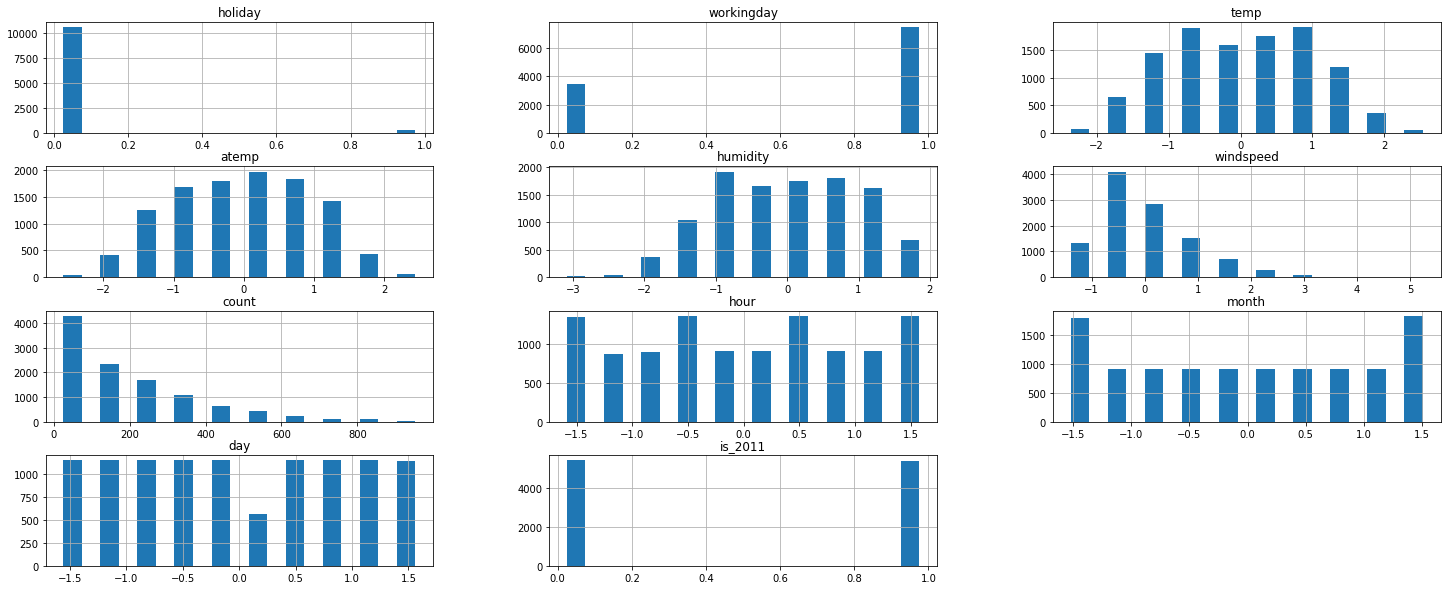

In [43]:
# View histogram of all features again now with the hour feature
train.hist(rwidth=0.5, figsize=(25, 10))

In [44]:
num_cols_test = [col for col in test.select_dtypes(include=['int', 'float']).columns.tolist() 
            if col not in ['holiday', 'workingday', 'is_2011']]
# # Standardize numerical variables
scaler = StandardScaler()
test[num_cols_test] = scaler.fit_transform(test[num_cols_test])

In [45]:
test.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,hour,month,day,is_2011
count,6493.000000,6493.000000,6.493000e+03,6.493000e+03,6.493000e+03,6.493000e+03,6.493000e+03,6.493000e+03,6.493000e+03,6493.000000
mean,0.029108,0.685815,-8.754569e-17,-2.801462e-16,-2.713917e-16,-1.225640e-16,-9.028150e-17,-3.501828e-17,3.873897e-16,0.496381
std,0.168123,0.464226,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,0.500025
min,0.000000,0.000000,-2.456967e+00,-2.734307e+00,-2.494581e+00,-1.531139e+00,-1.671785e+00,-1.622849e+00,-1.564633e+00,0.000000
25%,0.000000,0.000000,-8.289661e-01,-8.366899e-01,-7.840186e-01,-6.824227e-01,-8.037286e-01,-7.480088e-01,-9.656787e-01,0.000000
50%,0.000000,1.000000,8.678452e-02,1.124036e-01,4.534483e-02,-1.975579e-01,6.432770e-02,1.268314e-01,-6.724743e-02,0.000000
75%,0.000000,1.000000,7.990350e-01,8.024463e-01,8.747082e-01,5.293332e-01,9.323840e-01,1.001672e+00,8.311838e-01,1.000000
max,1.000000,1.000000,2.427036e+00,2.959114e+00,1.859577e+00,5.256968e+00,1.655764e+00,1.584898e+00,1.729615e+00,1.000000


In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  int64   
 2   workingday  10886 non-null  int64   
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  float64 
 7   windspeed   10886 non-null  float64 
 8   count       10886 non-null  int64   
 9   hour        10886 non-null  float64 
 10  month       10886 non-null  float64 
 11  day         10886 non-null  float64 
 12  is_2011     10886 non-null  int64   
dtypes: category(2), float64(7), int64(4)
memory usage: 957.2 KB


In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      6493 non-null   category
 1   holiday     6493 non-null   int64   
 2   workingday  6493 non-null   int64   
 3   weather     6493 non-null   category
 4   temp        6493 non-null   float64 
 5   atemp       6493 non-null   float64 
 6   humidity    6493 non-null   float64 
 7   windspeed   6493 non-null   float64 
 8   hour        6493 non-null   float64 
 9   month       6493 non-null   float64 
 10  day         6493 non-null   float64 
 11  is_2011     6493 non-null   int64   
dtypes: category(2), float64(7), int64(3)
memory usage: 520.4 KB


In [48]:
for i in train.select_dtypes(include='category').columns.tolist():
    print("{} has : {} unique values".format(i.capitalize(), len(train[i].unique())))

Season has : 4 unique values
Weather has : 3 unique values


In [49]:
for i in test.select_dtypes(include='category').columns.tolist():
    print("{} has : {} unique values".format(i.capitalize(), len(test[i].unique())))

Season has : 4 unique values
Weather has : 3 unique values


In [50]:
# create one-hot encoded columns for season and weather
season_dummies = pd.get_dummies(train['season'], prefix='season')
weather_dummies = pd.get_dummies(train['weather'], prefix='weather')

# add the new columns to the dataframe
train = pd.concat([train, season_dummies, weather_dummies], axis=1)

# remove the original categorical columns
train = train.drop(['season', 'weather'], axis=1)

In [51]:
# create one-hot encoded columns for season and weather
season_dummies_test = pd.get_dummies(test['season'], prefix='season')
weather_dummies_test = pd.get_dummies(test['weather'], prefix='weather')

# add the new columns to the dataframe
test = pd.concat([test, season_dummies_test, weather_dummies_test], axis=1)
# remove the original categorical columns
test = test.drop(['season', 'weather'], axis=1)

In [52]:
train.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,hour,month,day,is_2011,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3
0,0,0,-1.333661,-1.092737,0.993213,-1.567754,16,-1.668944,-1.603121,-1.64207,1,1,0,0,0,1,0,0
1,0,0,-1.438907,-1.182421,0.941249,-1.567754,40,-1.524341,-1.603121,-1.64207,1,1,0,0,0,1,0,0
2,0,0,-1.438907,-1.182421,0.941249,-1.567754,32,-1.379739,-1.603121,-1.64207,1,1,0,0,0,1,0,0
3,0,0,-1.333661,-1.092737,0.681430,-1.567754,13,-1.235137,-1.603121,-1.64207,1,1,0,0,0,1,0,0
4,0,0,-1.333661,-1.092737,0.681430,-1.567754,1,-1.090534,-1.603121,-1.64207,1,1,0,0,0,1,0,0


In [53]:
test.head()

,holiday,workingday,temp,atemp,humidity,windspeed,hour,month,day,is_2011,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3
0,0,1,-1.235966,-1.440193,-0.421172,1.620888,-1.671785,-1.622849,-1.564633,1,1,0,0,0,1,0,0
1,0,1,-1.235966,-1.181711,-0.421172,-1.531139,-1.527109,-1.622849,-1.564633,1,1,0,0,0,1,0,0
2,0,1,-1.235966,-1.181711,-0.421172,-1.531139,-1.382433,-1.622849,-1.564633,1,1,0,0,0,1,0,0
3,0,1,-1.235966,-1.267682,-0.421172,-0.197558,-1.237757,-1.622849,-1.564633,1,1,0,0,0,1,0,0
4,0,1,-1.235966,-1.267682,-0.421172,-0.197558,-1.093081,-1.622849,-1.564633,1,1,0,0,0,1,0,0


In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     10886 non-null  int64  
 1   workingday  10886 non-null  int64  
 2   temp        10886 non-null  float64
 3   atemp       10886 non-null  float64
 4   humidity    10886 non-null  float64
 5   windspeed   10886 non-null  float64
 6   count       10886 non-null  int64  
 7   hour        10886 non-null  float64
 8   month       10886 non-null  float64
 9   day         10886 non-null  float64
 10  is_2011     10886 non-null  int64  
 11  season_1    10886 non-null  uint8  
 12  season_2    10886 non-null  uint8  
 13  season_3    10886 non-null  uint8  
 14  season_4    10886 non-null  uint8  
 15  weather_1   10886 non-null  uint8  
 16  weather_2   10886 non-null  uint8  
 17  weather_3   10886 non-null  uint8  
dtypes: float64(7), int64(4), uint8(7)
memory usage: 1010.1 KB


## Step 5: Rerun the model with the same settings as before, just with more features

In [54]:
predictor_new_features = TabularPredictor(label="count", 
            eval_metric = 'root_mean_squared_error'
                            ).fit(train_data=train, 
            time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20230313_182918/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230313_182918/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Feb 1 21:34:38 UTC 2023
Train Data Rows:    10886
Train Data Columns: 17
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fea

In [55]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -35.712291      22.247961  550.362981                0.001310           0.449106            3       True         16
1      WeightedEnsemble_L2  -35.862526      19.163817  356.527305                0.001219           0.572806            2       True          9
2     ExtraTreesMSE_BAG_L2  -35.979602      20.976562  409.927620                0.607388           9.175986            2       True         14
3          CatBoost_BAG_L2  -36.069650      20.421536  436.576916                0.052361          35.825282            2       True         13
4          LightGBM_BAG_L2  -36.268487      20.479330  422.748124                0.110156          21.996490            2       True         11
5   RandomForestMSE_BAG_L2  -36.487640      20.987134  428.677856         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -113.0905023178959,
  'KNeighborsDist_BAG_L1': -108.22668502164065

[Text(-2.0, 0, 'KNeighborsDist_BAG_L1'),
 Text(0.0, 0, 'WeightedEnsemble_L3'),
 Text(2.0, 0, 'ExtraTreesMSE_BAG_L2'),
 Text(4.0, 0, 'LightGBM_BAG_L2'),
 Text(6.0, 0, 'NeuralNetFastAI_BAG_L2'),
 Text(8.0, 0, 'LightGBMXT_BAG_L1'),
 Text(10.0, 0, 'LightGBM_BAG_L1'),
 Text(12.0, 0, 'RandomForestMSE_BAG_L1'),
 Text(14.0, 0, 'KNeighborsDist_BAG_L1'),
 Text(16.0, 0, '')]

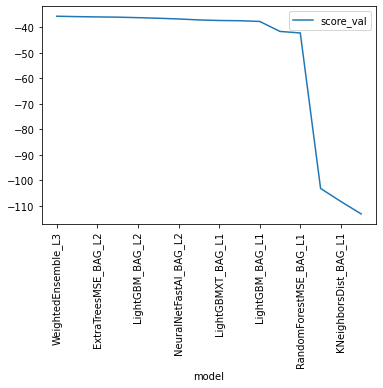

In [56]:
ax = predictor_new_features.leaderboard(silent=True).plot(kind="line", x="model", y="score_val")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [57]:
predictor_new_features.get_model_names()

['KNeighborsUnif_BAG_L1',
 'KNeighborsDist_BAG_L1',
 'LightGBMXT_BAG_L1',
 'LightGBM_BAG_L1',
 'RandomForestMSE_BAG_L1',
 'CatBoost_BAG_L1',
 'ExtraTreesMSE_BAG_L1',
 'NeuralNetFastAI_BAG_L1',
 'WeightedEnsemble_L2',
 'LightGBMXT_BAG_L2',
 'LightGBM_BAG_L2',
 'RandomForestMSE_BAG_L2',
 'CatBoost_BAG_L2',
 'ExtraTreesMSE_BAG_L2',
 'NeuralNetFastAI_BAG_L2',
 'WeightedEnsemble_L3']

In [58]:
best_model = predictor_new_features.get_model_best()
print("Best model: {}".format(best_model))

Best model: WeightedEnsemble_L3


In [59]:
predictors_new = predictor_new_features.predict(test)
predictors_new.head()

0    9.120630
1    5.090080
2    4.484694
3    3.765334
4    3.735077
Name: count, dtype: float32

In [60]:
predictors_new.describe()

count    6493.000000
mean      190.678421
std       174.988708
min         1.567207
25%        45.352432
50%       147.647690
75%       282.368378
max       889.069580
Name: count, dtype: float64

In [61]:
predictors_new =predictors_new.apply(lambda x: 0 if x < 0 else x)

In [62]:
# Remember to set all negative values to zero
submission_new_features = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'],
                date_parser=custom_date_parser)

In [63]:
# Same submitting predictions
submission_new_features["count"] = predictors_new
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [117]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "final_submission_with_n_features"

100%|█████████████████████████████████████████| 242k/242k [00:00<00:00, 519kB/s]
Successfully submitted to Bike Sharing Demand

In [119]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                            status    publicScore  privateScore  
---------------------------  -------------------  -------------------------------------  --------  -----------  ------------  
submission_new_features.csv  2023-03-13 19:28:47  final_submission_with_n_features       complete  0.45882      0.45882       
submission_new_hpo.csv       2023-03-13 19:21:26  final_submission_hyperparameter tuned  complete  0.58289      0.58289       
submission_xgb.csv           2023-03-13 19:20:51  final_submission_xgb_model             complete  0.80166      0.80166       
submission_new_hpo.csv       2023-03-12 18:45:54  new features with hyperparameters_V3   complete  0.53981      0.53981       


#### New Score of 0.45882

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [71]:
hyperparameters = {
    "NN": {'learning_rate': 0.001,
        'weight_decay': 0.01,
        'dropout_prob': 0.2,
        'activation': 'relu',
        'num_layers': 3,
        'num_hidden_units': [64, 32, 16]},
    "GBM": [
        {"learning_rate": 0.1, 'feature_fraction': 1.0, 'bagging_fraction': 1.0,'bagging_freq': 0,'min_data_in_leaf': 20,'num_threads': -1},
        {"learning_rate": 0.1, 'feature_fraction': 0.6, 'bagging_fraction': 0.6, 'bagging_freq': 10, 'min_data_in_leaf': 30, 'num_threads': -1}
    ],
    "XGB": {"n_estimators": 200, "learning_rate": 0.03, 'subsample': 0.5, 'colsample_bytree': 0.8, 'max_depth': 6, 'min_child_weight': 4},
    "LR": {"penalty": "l2", "solver": "lbfgs"},
}
hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': 5,
    'scheduler' : 'local',
    'searcher': 'auto'
}


predictor_new_hpo = TabularPredictor(label="count", eval_metric='root_mean_squared_error', problem_type="regression").fit(train_data=train,
            time_limit=600, presets="best_quality", 
        hyperparameters=hyperparameters, 
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

No path specified. Models will be saved in: "AutogluonModels/ag-20230313_184551/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230313_184551/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Feb 1 21:34:38 UTC 2023
Train Data Rows:    10886
Train Data Columns: 17
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1796.63 MB
	Train Data (Original)  Memory Usage: 0.95 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note:

In [72]:
predictor_new_hpo.fit_summary()

2023-03-13 18:53:15,422	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.


*** Summary of fit() ***
Estimated performance of each model:
                   model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    WeightedEnsemble_L2 -36.557681       5.987401  243.680590                0.001009           0.297809            2       True          5
1     LightGBM_BAG_L1/T2 -36.939139       1.298291   62.241554                1.298291          62.241554            1       True          2
2     LightGBM_BAG_L1/T1 -37.128355       1.894256   67.249151                1.894256          67.249151            1       True          1
3    WeightedEnsemble_L3 -37.128649       5.988459  336.559798                0.001450           0.595743            3       True         11
4   LightGBM_2_BAG_L2/T1 -37.327928       5.986562  267.605332                0.000170          24.222550            2       True          8
5     LightGBM_BAG_L2/T1 -37.372002       5.986530  267.215315                0.000137      

{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_2_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_2_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_2_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1/T1': -37.12835503551873,
  'LightGBM_BAG_L1/T2': -36.93913852380001,
  'LightGBM_2_BAG_L1/T1': -38.17555503916761,
  'XGBoost_BAG_L1': -45.51052254717829,
  'WeightedEnsemble_L2': -36.557681486649955,
  'LightGBM_BAG_L2/T1': -37.37200171433251,
  'LightGBM_BAG_L2/T2': -37.65922758986798,
  'LightGBM_2_BAG_L2/T1': -37.32792751068972,
  'LightGBM_2_BAG_L2/T2': -37.53271

[Text(-2.0, 0, 'LightGBM_2_BAG_L1/T1'),
 Text(0.0, 0, 'WeightedEnsemble_L2'),
 Text(2.0, 0, 'LightGBM_BAG_L1/T1'),
 Text(4.0, 0, 'LightGBM_2_BAG_L2/T1'),
 Text(6.0, 0, 'XGBoost_BAG_L2'),
 Text(8.0, 0, 'LightGBM_BAG_L2/T2'),
 Text(10.0, 0, 'XGBoost_BAG_L1'),
 Text(12.0, 0, '')]

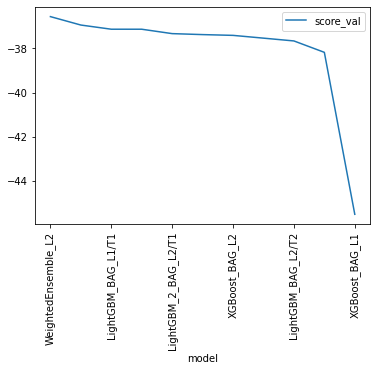

In [73]:
ax = predictor_new_hpo.leaderboard(silent=True).plot(kind="line", x="model", y="score_val")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [74]:
best_model = predictor_new_hpo.get_model_best()
print(best_model)

WeightedEnsemble_L2


In [75]:
# Remember to set all negative values to zero
predictions_hypo = predictor_new_hpo.predict(test)
predictions_hypo.head()

0    4.812192
1   -5.477009
2   -6.882030
3   -3.535486
4   -4.091662
Name: count, dtype: float32

In [76]:
predictions_hypo.describe()

count    6493.000000
mean      191.316071
std       174.513458
min       -19.003437
25%        46.293293
50%       151.254288
75%       283.470490
max       931.610901
Name: count, dtype: float64

In [77]:
predictions_hypo = predictions_hypo.clip(lower=0)
predictions_hypo.describe()

count    6493.000000
mean      191.401703
std       174.417755
min         0.000000
25%        46.293293
50%       151.254288
75%       283.470490
max       931.610901
Name: count, dtype: float64

In [78]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'],
                date_parser=custom_date_parser)


In [79]:
submission_new_hpo['count'] = predictions_hypo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [109]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "final_submission_hyperparameter tuned"

100%|█████████████████████████████████████████| 187k/187k [00:00<00:00, 408kB/s]
Successfully submitted to Bike Sharing Demand

In [111]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                            status    publicScore  privateScore  
---------------------------  -------------------  -------------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-03-13 19:21:26  final_submission_hyperparameter tuned  complete  0.58289      0.58289       
submission_xgb.csv           2023-03-13 19:20:51  final_submission_xgb_model             complete  0.80166      0.80166       
submission_new_hpo.csv       2023-03-12 18:45:54  new features with hyperparameters_V3   complete  0.53981      0.53981       
submission_new_features.csv  2023-03-12 18:19:07  new features_updated_with_is2011       complete  0.45930      0.45930       


#### New Score of 0.58289     

### XGBoost model

In [82]:
X_train = train.drop(["count"], axis=1)
y_train = train["count"]
xgb_model = xgb.XGBRegressor()
# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 1],
    'colsample_bytree': [0.5, 1],
    'reg_alpha': [0, 1, 10],
    'reg_lambda': [0, 1, 10]
}

# Define the grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding mean squared error
print('Best hyperparameters:', grid_search.best_params_)
print('Best mean squared error:', -grid_search.best_score_)

Best hyperparameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 10, 'reg_lambda': 1, 'subsample': 1}
Best mean squared error: 4187.8557586086945


ValueError: Experimental support for categorical data is not implemented for current tree method yet.

In [100]:
# Use the best hyperparameters to train a final XGBoost model on the entire training data
final_model = xgb.XGBRegressor(**grid_search.best_params_)
final_model.fit(X_train, y_train)
predictions_xgb = pd.Series(final_model.predict(test))

In [102]:
predictions_xgb.describe()

count    6493.000000
mean      189.652206
std       172.873123
min       -74.168968
25%        44.711086
50%       151.681107
75%       290.519592
max       877.619080
dtype: float64

In [103]:
predictions_xgb = predictions_xgb.clip(lower=0)
predictions_xgb.describe()

count    6493.000000
mean      190.503082
std       171.857727
min         0.000000
25%        44.711086
50%       151.681107
75%       290.519592
max       877.619080
dtype: float64

In [104]:
# Same submitting predictions
submission_xgb= pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'],
                date_parser=custom_date_parser)

In [105]:
submission_xgb['count'] = predictions_xgb
submission_xgb.to_csv("submission_xgb.csv", index=False)

In [106]:
!kaggle competitions submit -c bike-sharing-demand -f submission_xgb.csv -m "final_submission_xgb_model"

100%|█████████████████████████████████████████| 186k/186k [00:00<00:00, 414kB/s]
Successfully submitted to Bike Sharing Demand

In [108]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                           status    publicScore  privateScore  
---------------------------  -------------------  ------------------------------------  --------  -----------  ------------  
submission_xgb.csv           2023-03-13 19:20:51  final_submission_xgb_model            complete  0.80166      0.80166       
submission_new_hpo.csv       2023-03-12 18:45:54  new features with hyperparameters_V3  complete  0.53981      0.53981       
submission_new_features.csv  2023-03-12 18:19:07  new features_updated_with_is2011      complete  0.45930      0.45930       
submission_new_hpo.csv       2023-03-11 00:06:04  new features with hyperparameters_V2  complete  0.54948      0.54948       


## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

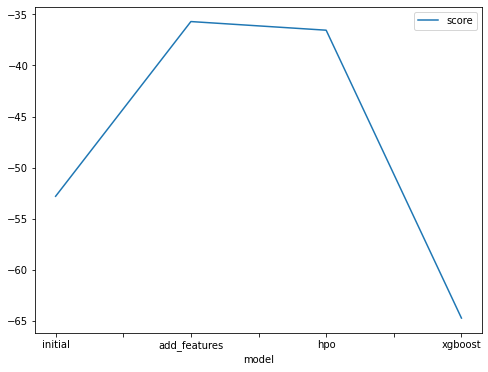

In [5]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo", "xgboost"],
        "score": [-52.800161, -35.712291, -36.557681, -64.7112]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

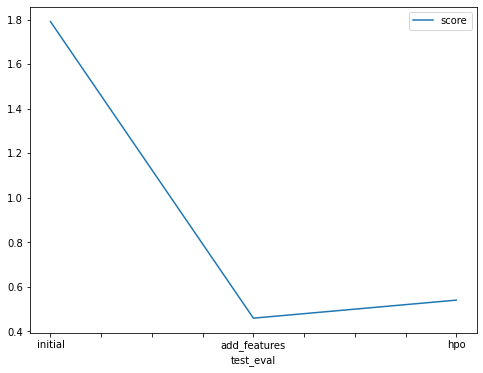

In [120]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.79038, 0.45882, 0.53981 ]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [116]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ["N/A", "N/A", "num_boost_round"],
    "hpo2": ["N/A", "N/A", "learning_rate"],
    "hpo3": ["N/A", "N/A", "feature_fraction"],
    "score": [1.79038, 0.45882, 0.53981]
})

,model,hpo1,hpo2,hpo3,score
0,initial,N/A,N/A,N/A,1.79038
1,add_features,N/A,N/A,N/A,0.45930
2,hpo,num_boost_round,learning_rate,feature_fraction,0.54948
